## Acquisition success yearly trending

To run this standalone on the HEAD or GRETA networks:
```
# Get into Ska3 environment
git clone https://github.com/sot/aca_stats.git
cd aca_stats
jupyter nbconvert --to notebook --execute acq-success-trend-yearly.ipynb
ls -lrt
```
This will create the png and csv output files.

In [1]:
import numpy as np
import agasc
from agasc import get_supplement_table
%matplotlib inline
from astropy.table import Table
from mica.stats.acq_stats import get_stats
from cxotime import CxoTime
import matplotlib.pyplot as plt
from chandra_aca.star_probs import binom_ppf

In [2]:
stats = Table(get_stats())
len(stats)

316784

In [3]:
# Make truncated year column for doing grouping. If current time is less than
# half way through the year then slosh that data into the previous year.
curr_year = CxoTime.now().decimalyear
curr_year_trunc = np.trunc(curr_year)
obs_year = CxoTime(stats["guide_tstart"]).decimalyear
if curr_year - curr_year_trunc < 0.5:
    obs_year = obs_year.clip(None, curr_year_trunc - 1)
stats["iyear"] = np.trunc(obs_year)

In [4]:
# Update to use AGASC 1.8 mags
stars = agasc.get_stars(stats["agasc_id"], agasc_file="agasc*")
stats["mag"] = stars["MAG_ACA"]

In [5]:
stats

obsid,obi,acq_start,guide_start,guide_tstart,one_shot_length,revision,slot,idx,type,yang,zang,halfw,mag,acqid,star_tracked,spoiler_tracked,img_func,n_trak_interv,max_trak_cdy,min_trak_cdy,mean_trak_cdy,max_trak_cdz,min_trak_cdz,mean_trak_cdz,max_trak_mag,min_trak_mag,mean_trak_mag,cdy,cdz,dy,dz,ion_rad,def_pix,mult_star,sat_pix,mag_obs,yang_obs,zang_obs,agasc_id,color1,ra,dec,epoch,pm_ra,pm_dec,var,pos_err,mag_aca,mag_err,mag_band,pos_catid,aspq1,aspq2,aspq3,acqq1,acqq2,acqq4,n100_warm_frac,ccd_temp,known_bad,bad_comment,iyear
int64,int64,bytes21,bytes21,float64,float64,bytes15,int64,int64,bytes5,float64,float64,int64,float32,bool,bool,bool,bytes7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bytes15,float64
61357,0,2002:007:13:55:23.988,2002:007:13:55:59.863,126799024.04699999,0.0,1.0,0,1,BOT,-1852.0,-654.0,120,7.2536197,True,True,False,star,1,0.2193248181411036,-0.010515448316027687,0.04967300760940816,-0.6112363680218778,-0.6804457324344639,-0.6386536738424183,7.25,7.25,7.25,0.01763037070122664,-0.6325783695616565,-3.2892026012571023,-3.528618260200915,False,False,False,False,7.25,-1864.0500000000002,-650.3000000000001,153617000,1.5,353.58682532,12.36721959,2000.0,-38,-26,-9999,12,7.159948348999023,1,4,5,0,0,999,-9999,-9999,383,0.04750567177429073,-10.3720703125,False,,2002.0
61357,0,2002:007:13:55:23.988,2002:007:13:55:59.863,126799024.04699999,0.0,1.0,1,2,BOT,2091.0,794.0,120,8.811338,True,True,False,star,1,0.11663758843451433,0.04477023634035504,0.08730495218675233,0.14123420957321287,0.06215776407668727,0.10089599835496951,8.8125,8.8125,8.8125,0.057945085762185045,0.0804956919171218,-3.2450961251320223,-2.82598407727005,False,False,False,False,8.8125,2079.775,799.2750000000001,153626944,1.4849505424499512,354.47878604,11.59214372,2000.0,-14,-22,-9999,23,8.843986511230469,2,4,5,0,0,999,-9999,482,482,0.04750567177429073,-10.3720703125,False,,2002.0
61357,0,2002:007:13:55:23.988,2002:007:13:55:59.863,126799024.04699999,0.0,1.0,2,3,BOT,1549.0,1932.0,120,9.030227,True,True,False,star,1,0.27760541233601543,0.1818339459946401,0.2349458822035558,0.04016911882308705,-0.03717596836077064,0.008953986077131049,9.0625,9.0625,9.0625,0.27285027704692766,0.02244954521870568,-3.027278919837272,-2.8827043241885804,False,False,False,False,9.0625,1538.825,1937.15,153622384,1.2622497081756592,354.69122915,11.8736307,2000.0,16,-20,-9999,19,8.969228744506836,2,4,5,0,0,999,-9999,-9999,101,0.04750567177429073,-10.3720703125,False,,2002.0
61357,0,2002:007:13:55:23.988,2002:007:13:55:59.863,126799024.04699999,0.0,1.0,3,4,BOT,-861.0,379.0,120,8.78108,True,True,False,star,1,0.28792946721398494,0.23061748430029638,0.25849668221444844,-0.4149643006598467,-0.46172393911552945,-0.43721696952228023,8.8125,8.8125,8.8125,0.2539138290956089,-0.44054369366648416,-3.050084902916751,-3.339078133630153,False,False,False,False,8.8125,-872.725,384.27500000000003,153619752,1.0998997688293457,353.97926272,12.26080987,2000.0,6,-26,-9999,21,8.88244915008545,2,4,5,0,0,999,-9999,243,243,0.04750567177429073,-10.3720703125,False,,2002.0
61357,0,2002:007:13:55:23.988,2002:007:13:55:59.863,126799024.04699999,0.0,1.0,4,5,BOT,1198.0,-1606.0,120,8.920914,True,True,False,star,1,0.20299084681118984,0.11067597488772662,0.14975276157093292,-0.40152063407049354,-0.48982603756462595,-0.45003231552473505,8.9375,8.9375,8.9375,0.13236012585252865,-0.4585582546653768,-3.1767706707614707,-3.3624060589122564,False,False,False,False,8.9375,1187.125,-1601.75,153617544,1.1330493688583374,353.75939831,11.49564178,2000.0,-9999,-9999,-9999,30,9.038054466247559,3,4,5,0,0,999,-9999,-9999,374,0.04750567177429073,-10.3720703125,False,,2002.0
61357,0,2002:007:13:55:23.988,2002:007:13:55:59.863,126799024.04699999,0.0,1.0,5,6,BOT,562.0,-1604.0,120,9.6

In [6]:
# Correct ACA mags using AGASC supplement
obs_mags = get_supplement_table("mags", as_dict=True)
n_match = 0
for row in stats:
    try:
        row["mag"] = obs_mags[row["agasc_id"]]["mag_aca"]
        n_match += 1
    except KeyError:
        pass
print(n_match)

264273


In [7]:
# Select only faint stars.
# Original version of notebook filtered on stats['halfw'] >= 120 but don't do that here.
ok = (stats["mag"] >= 9.6) & (stats["mag"] < 10.6)
sok = stats[ok]

In [8]:
len(sok)

72055

In [9]:
n_match

264273

In [10]:
sok["imag"] = np.trunc(sok["mag"] * 5) / 5

In [11]:
sg = sok.group_by(keys=["imag", "iyear"])["imag", "iyear", "star_tracked"]

In [12]:
len(sg.groups)

115

In [13]:
rows = []
for grp in sg.groups:
    n_tracked = np.sum(grp["star_tracked"])
    n_obs = len(grp)
    f_track = n_tracked / n_obs
    err_m, err_p = binom_ppf(n_tracked, n_obs, [0.16, 0.84]) - f_track
    row = (
        grp["imag"][0],
        grp["iyear"][0] + 0.5,
        n_tracked,
        n_obs,
        f_track.round(3),
        err_m.round(4),
        err_p.round(4),
    )
    rows.append(row)
sga = Table(
    rows=rows,
    names=["imag", "iyear", "n_tracked", "n_obs", "frac_tracked", "err_m", "err_p"],
)

In [14]:
sga

imag,iyear,n_tracked,n_obs,frac_tracked,err_m,err_p
float32,float64,int64,int64,float64,float64,float64
9.6,2002.5,558,566,0.986,-0.0073,0.0029
9.6,2003.5,883,900,0.981,-0.0061,0.003
9.6,2004.5,751,761,0.987,-0.006,0.0025
9.6,2005.5,863,872,0.99,-0.0052,0.0019
9.6,2006.5,904,922,0.98,-0.0062,0.0031
9.6,2007.5,907,926,0.979,-0.0062,0.0032
9.6,2008.5,983,992,0.991,-0.0046,0.0016
9.6,2009.5,1087,1098,0.99,-0.0045,0.0017
9.6,2010.5,1038,1050,0.989,-0.0048,0.0019


In [15]:
# The mean of the star_tracked 0's and 1's is the tracking fraction.
# sga = sg.groups.aggregate(np.mean)

In [16]:
proseco_time = CxoTime("2019:021")
maxmag_clip = CxoTime("2019:175")

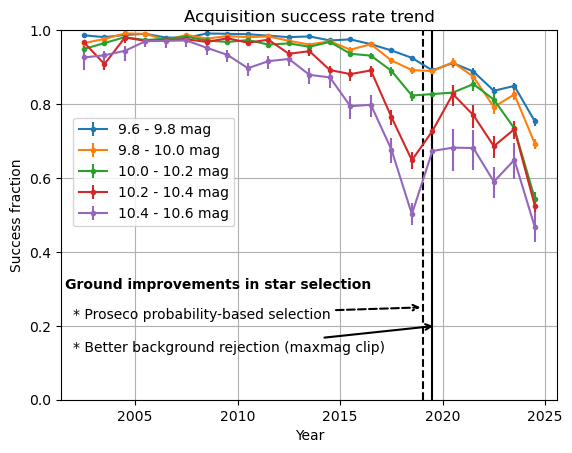

In [20]:
# Make the plot
fig, ax = plt.subplots()
imags = sorted(set(sga["imag"]))
for imag in imags:
    ok = sga["imag"] == imag
    ax.errorbar(
        sga["iyear"][ok],
        sga["frac_tracked"][ok],
        yerr=[-sga["err_m"][ok], sga["err_p"][ok]],
        fmt="-o",
        ms=3,
        label=f"{imag:.1f} - {imag+0.2:.1f} mag",
    )
ax.legend(loc="lower left", bbox_to_anchor=(0.01, 0.45))
ax.grid()
ax.set_title("Acquisition success rate trend")
ax.set_ylabel("Success fraction")
ax.set_xlabel("Year")
ax.set_ylim(0, 1)

ax.axvline(
    proseco_time.frac_year, color='k', linestyle='--', label='Proseco time')
ax.axvline(
    maxmag_clip.frac_year, color='k', linestyle='-', label='Maxmag clip time')

ax.annotate("Ground improvements in star selection",
            xy=(proseco_time.frac_year, 0.3),
            xytext=(proseco_time.frac_year - 17.5, 0.30),
            fontweight='bold')

# First arrow for "proseco probability-based selection"
ax.annotate(
    "* Proseco probability-based selection",
    xy=(proseco_time.frac_year, 0.25),  # Arrow points to this location
    xytext=(proseco_time.frac_year - 17.1, 0.22),  # Text location
    arrowprops=dict(arrowstyle="->", lw=1.5, linestyle='dashed'),
)

# Second arrow for "better background rejection (maxmag clip)"
ax.annotate(
    "* Better background rejection (maxmag clip)",
    xy=(maxmag_clip.frac_year + .2, 0.20),  # Arrow points to this location
    xytext=(maxmag_clip.frac_year - 17.5, 0.13),  # Text location
    arrowprops=dict(arrowstyle="->", lw=1.5, linestyle='solid'),
)


plt.savefig("acq_success_yearly.png", dpi=150)

In [21]:
sga.write("acq_success_yearly.csv", overwrite=True)

In [19]:
pwd

'/Users/jean/git/aca_stats'